# Number Recognizer (教師あり学習)

今回は、ブラウザ上に書いた手書きの数字を認識させます。具体的には、canvasに書かれた数字が0～9のどれであるかを当てさせます。  
その予測を行うためのモデルを、以下のステップに沿って作成していきます。


* [データロード](#Load-the-Data)
* [モデル構築](#Create-the-Model)
* [学習](#Training-the-Model)
* [評価](#Evaluate-the-Model)
* [保存](#Store-the-Model)


In [1]:
# グラフが文章中に表示されるようにするおまじない
%matplotlib inline

## Load the Data

scikit-learnには、最初から手書きの数字を認識するための学習データ(手書き数字の画像データと、その画像の数字が0～9の何れであるかという答えのセット)が搭載されているため、それを利用します。

In [2]:
def load_data():
    from sklearn import datasets
    dataset = datasets.load_digits()
    return dataset

digits = load_data() # データ
print(digits.data.shape)

(1797, 64)


/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


`1797`は行数、`64`は次元数です。手書き文字の画像データが8×8のサイズであるため、その中のピクセル情報は64となります(今回値はグレースケールですが、RGBの場合3倍になります)。

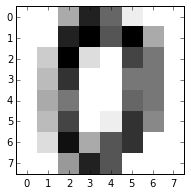

In [3]:
def show_image(image):
    import matplotlib.pyplot as plt

    plt.figure(1, figsize=(3, 3))
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

show_image(digits.images[0])

## Create the Model

今回扱うのは画像の分類問題になります。そこで、シンプルな線形分類機であるSGDClassifierを利用します。

In [4]:
def make_model():
    from sklearn.linear_model import SGDClassifier    
    clf = SGDClassifier(alpha=0.0001, fit_intercept=True, n_iter=200)
    return clf
    
classifier = make_model() # モデル

## Training the Model

データとモデルがそろったため、学習させてみます。

### [#2] 学習データの分割

学習させる時はトレーニングセットを使うようにする。`cross_validation.train_test_split` で分割ができる

### [Advanced] 分けたデータの中身

9番だけない、とかだと一部だけ精度の悪いモデルが出来る

In [5]:
def split_dataset(dataset, test_size=0.3):
    from sklearn import cross_validation
    from collections import namedtuple

    DataSet = namedtuple("DataSet", ["data", "target"])
    train_d, test_d, train_t, test_t = \
        cross_validation.train_test_split(dataset.data,
                                          dataset.target,
                                          test_size=test_size,
                                          random_state=0)

    left = DataSet(train_d, train_t)
    right = DataSet(test_d, test_t)

    return left, right

# use 30% of data to test the model
training_set, test_set = split_dataset(digits, 0.3)

print(
    "dataset is splited to train/test = ",
    "{0} -> {1}, {2}".format(
        len(digits.data),
        len(training_set.data),
        len(test_set.data))
     )

dataset is splited to train/test =  1797 -> 1257, 540


In [6]:
# classifier.fit(digits.data, digits.target)
classifier.fit(training_set.data, training_set.target)

/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=200, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

### [Advanced] モデルのチューニング

↑ハイパーパラメータ、これを変えてチューニングしていく...が全ての組合せを貯めするのが、 `GridSearchCV`

モデルの学習のUndo ReDoは仕組み上不可能、オンライン学習ではモデルに入れる前に適応しているかどうか判断した上で投入など、手法がある。(オンライン学習の青本が有名)

In [7]:
def tuning_model(model_func, dataset):
    from sklearn.grid_search import GridSearchCV

    candidates = [
        {"loss": ["hinge", "log"],
         "alpha": [1e-5, 1e-4, 1e-3]
        }]

    searcher = GridSearchCV(model_func(), candidates, cv=5, scoring="f1_weighted")
    searcher.fit(dataset.data, dataset.target)

    for params, mean_score, scores in sorted(searcher.grid_scores_, key=lambda s: s[1], reverse=True):
        print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))

    return searcher.best_estimator_

classifier = tuning_model(make_model, digits)

/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs,

0.908 (+/-0.015) for {'alpha': 0.001, 'loss': 'log'}
0.905 (+/-0.014) for {'alpha': 0.0001, 'loss': 'hinge'}
0.900 (+/-0.015) for {'alpha': 1e-05, 'loss': 'log'}
0.900 (+/-0.015) for {'alpha': 1e-05, 'loss': 'hinge'}
0.899 (+/-0.014) for {'alpha': 0.001, 'loss': 'hinge'}
0.893 (+/-0.019) for {'alpha': 0.0001, 'loss': 'log'}


/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


In [8]:
classifier

/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=200, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

## Evaluate the Model

学習させたモデルの精度を計測してみます。`predict`で予測させることができるので、これで予測させた値と実際の答え(`digits.target`)を比べてみます。

In [11]:
def calculate_accuracy(model, dataset):  # (モデル, データ)
    from sklearn import metrics

    predicted = model.predict(dataset.data)
    score = metrics.accuracy_score(dataset.target, predicted)
    return score

print(calculate_accuracy(classifier, training_set))
print(calculate_accuracy(classifier, test_set))

0.979315831344
0.981481481481


### [#3] モデルの評価

精度がいいからで安心はダメ

過学習と非平衡が起こっていないかを確かめる

/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/nishiyamahiroto/.pyenv/versions/anaconda3-2.3.0/envs/ml_env/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs,

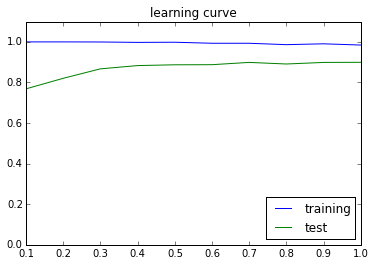

In [10]:
def plot_learning_curve(model_func, dataset):
    from sklearn.learning_curve import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np

    sizes = [i / 10 for i in range(1, 11)]
    train_sizes, train_scores, valid_scores = learning_curve(model_func(), dataset.data, dataset.target, train_sizes=sizes, cv=5)

    take_means = lambda s: np.mean(s, axis=1)
    plt.plot(sizes, take_means(train_scores), label="training")
    plt.plot(sizes, take_means(valid_scores), label="test")
    plt.ylim(0, 1.1)
    plt.title("learning curve")
    plt.legend(loc="lower right")
    plt.show()

plot_learning_curve(make_model, digits)

`learning_curve` で過学習をチェック

- trainingは過学習により、下がってくる
- testはデータが増えることで、上がってくる

In [12]:
def show_confusion_matrix(model, dataset):
    from sklearn.metrics import classification_report

    predicted = model.predict(dataset.data)
    target_names = ["#{0}".format(i) for i in range(0, 10)]

    print(classification_report(dataset.target, predicted, target_names=target_names))

show_confusion_matrix(classifier, digits)

             precision    recall  f1-score   support

         #0       1.00      1.00      1.00       178
         #1       0.99      0.89      0.94       182
         #2       1.00      0.99      1.00       177
         #3       0.99      0.97      0.98       183
         #4       1.00      0.99      1.00       181
         #5       0.99      0.99      0.99       182
         #6       1.00      0.99      1.00       181
         #7       0.99      0.99      0.99       179
         #8       0.85      0.99      0.92       174
         #9       0.99      0.98      0.99       180

avg / total       0.98      0.98      0.98      1797



- precision: 資料のA、シュートの精度
- recall: 資料のB、シュートの確率
- f1スコア: 適合率と再現率はトレードオフ、このバランスを示す

## Store the Model

最後に、学習させたモデルを保存します。アプリケーション側で、その結果を確認してみてください。

In [13]:
from sklearn.externals import joblib

joblib.dump(classifier, "./machine.pkl") 

['./machine.pkl',
 './machine.pkl_01.npy',
 './machine.pkl_02.npy',
 './machine.pkl_03.npy',
 './machine.pkl_04.npy']